# **PromptBindInference Use Case Notebook**

## **1. Setup Environment**

In [5]:
import numpy as np
import os
import torch
import sys
import argparse
import random
from datetime import datetime

from safetensors.torch import load_model
import yaml

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [6]:
promptbind_src = "./promptbind"
sys.path.insert(0, promptbind_src)

from promptbind.data.data import get_data
from promptbind.utils.metrics import *
from promptbind.utils.utils import *
from promptbind.utils.logging_utils import Logger
from promptbind.models.model import *

/home/kevinb/miniconda3/envs/promptbind/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **2. Initialize Configuration**

In [3]:
data_path = "/home/kevinb/nas/protein/data/pdbbind2020"
prompt_nf = 8
result_folder = "./results"
exp_name = f"test_prompt_{prompt_nf}"

In [4]:
config_path = 'options/test_args.yml'
with open(config_path, 'r') as f:
    args_dict = yaml.safe_load(f)
combined_args_dict = {**args_dict['config'], **args_dict['args']}

combined_args_dict['data_path'] = data_path
combined_args_dict['pocket_prompt_nf'] = prompt_nf
combined_args_dict['complex_prompt_nf'] = prompt_nf
combined_args_dict['resultFolder'] = result_folder
combined_args_dict['exp_name'] = f"test_prompt_{prompt_nf}"
combined_args_dict['ckpt'] = f"pretrained/prompt_{prompt_nf}/best/model.safetensors"

args = argparse.Namespace(**combined_args_dict)

torch.manual_seed(args.seed)
random.seed(args.seed)
np.random.seed(args.seed)

In [5]:
pre = f"{args.resultFolder}/{args.exp_name}"
os.makedirs(pre, exist_ok=True)

logger = Logger(accelerator=None, log_path=f'{pre}/test.log')
logger.log_message(f"{' '.join(sys.argv)}")

11/01/2024 18:07:43 - INFO - MainLogger - Working directory is /home/kevinb/protein/PromptBind
11/01/2024 18:07:43 - INFO - MainLogger - /home/kevinb/miniconda3/envs/promptbind/lib/python3.10/site-packages/ipykernel_launcher.py --f=/home/kevinb/.local/share/jupyter/runtime/kernel-v36055f1fa0bbe671ac110c56682a094097a0a6992.json


## **3. Initialize and Run Inference**

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

model = get_model(args, logger, device)
load_model(model, args.ckpt)
model.to(device)

import torch.nn as nn

if args.pred_dis:
    criterion = nn.MSELoss()
    pred_dis = True
else:
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(args.posweight).to(device))

if args.coord_loss_function == 'MSE':
    com_coord_criterion = nn.MSELoss()
elif args.coord_loss_function == 'SmoothL1':
    com_coord_criterion = nn.SmoothL1Loss()

if args.pocket_cls_loss_func == 'bce':
    pocket_cls_criterion = nn.BCEWithLogitsLoss(reduction='mean')

pocket_coord_criterion = nn.HuberLoss(delta=args.pocket_coord_huber_delta)

11/01/2024 18:07:43 - INFO - MainLogger - PromptBind


Using device: cuda


In [7]:
if args.redocking:
    args.compound_coords_init_mode = "redocking"
elif args.redocking_no_rotate:
    args.redocking = True
    args.compound_coords_init_mode = "redocking_no_rotate"

train, valid, test = get_data(
    args,
    logger,
    addNoise=args.addNoise,
    use_whole_protein=args.use_whole_protein,
    compound_coords_init_mode=args.compound_coords_init_mode,
    pre=args.data_path,
)
logger.log_message(
    f"Data points - Train: {len(train)}, Valid: {len(valid)}, Test: {len(test)}"
)

num_workers = 0

from torch_geometric.loader import DataLoader

test_loader = DataLoader(
    test,
    batch_size=args.batch_size,
    follow_batch=['x', 'compound_pair'],
    shuffle=False,
    pin_memory=False,
    num_workers=num_workers,
)

with open('split_pdb_id/unseen_test_index') as f:
    test_unseen_pdb_list = [line.strip() for line in f]

test_unseen_index = test.data.query(
    "(group =='test') and (pdb in @test_unseen_pdb_list)"
).index.values
test_unseen_index_for_select = np.array(
    [np.where(test._indices == i)[0][0] for i in test_unseen_index]
)
test_unseen = test.index_select(test_unseen_index_for_select)

test_unseen_loader = DataLoader(
    test_unseen,
    batch_size=args.batch_size,
    follow_batch=['x', 'compound_pair'],
    shuffle=False,
    pin_memory=False,
    num_workers=num_workers,
)

11/01/2024 18:07:44 - INFO - MainLogger - Loading dataset
11/01/2024 18:07:44 - INFO - MainLogger - compound feature based on torchdrug
11/01/2024 18:07:44 - INFO - MainLogger - protein feature based on esm2
/home/kevinb/protein/PromptBind/promptbind/data/data.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case

['/home/kevinb/nas/protein/data/pdbbind2020/dataset/processed/data.pt', '/home/kevinb/nas/protein/data/pdbbind2020/dataset/processed/protein_1d_3d.lmdb', '/home/kevinb/nas/protein/data/pdbbind2020/dataset/processed/compound_LAS_edge_index.lmdb', '/home/kevinb/nas/protein/data/pdbbind2020/dataset/processed/compound_rdkit_coords.pt', '/home/kevinb/nas/protein/data/pdbbind2020/dataset/processed/esm2_t33_650M_UR50D.lmdb']


/home/kevinb/protein/PromptBind/promptbind/data/data.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.compound_rdkit_coords = torch.load(self.processed_paths[3])
11

In [8]:
model.eval()
logger.log_message("Begin testing")
(
    metrics, _, _,
    _, _,
    _, _
) = evaluate_mean_pocket_cls_coord_multi_task(
    accelerator=None,
    args=args,
    data_loader=test_unseen_loader,
    model=model,
    com_coord_criterion=com_coord_criterion,
    criterion=criterion,
    pocket_cls_criterion=pocket_cls_criterion,
    pocket_coord_criterion=pocket_coord_criterion,
    relative_k=args.relative_k,
    device=device,
    pred_dis=args.pred_dis,
    use_y_mask=False,
    stage=2
)

logger.log_stats(metrics, 0, args, prefix="Test_unseen")

11/01/2024 18:07:45 - INFO - MainLogger - Begin testing
100%|██████████| 36/36 [00:32<00:00,  1.10it/s]
11/01/2024 18:08:18 - INFO - MainLogger - [Test_unseen] Epoch 0 out of 400 | Samples --> 144.00000 | Skip_samples --> 1.00000 | Keepnode < 5 --> 0.00000 | Contact_loss --> 1.13186 | Contact_by_pred_loss --> 1.19398 | Com_coord_huber_loss --> 4.27379 | Rmsd --> 7.95665 | Rmsd < 2a --> 0.21528 | Rmsd < 5a --> 0.57639 | Rmsd 25% --> 2.12651 | Rmsd 50% --> 3.74071 | Rmsd 75% --> 9.29415 | Centroid_dis --> 6.21516 | Centroid_dis < 2a --> 0.54167 | Centroid_dis < 5a --> 0.74306 | Centroid_dis 25% --> 0.98512 | Centroid_dis 50% --> 1.66359 | Centroid_dis 75% --> 5.20561 | Pocket_cls_bce_loss --> 0.57726 | Pocket_coord_mse_loss --> 0.45735 | Pocket_cls_accuracy --> 0.82094 | Pocket_pearson --> 0.65176 | Pocket_rmse --> 7.00585 | Pocket_mae --> 4.20523 | Pocket_center_avg_dist --> 8.34821 | Pocket_center_dcc --> 34.72222 | 


## **4. Visualize Prediction**

In [9]:
pdb_folder = './example'
pdb_files = [f for f in os.listdir(pdb_folder) if f.endswith('.pdb')]
target_pdb_ids = [os.path.splitext(f)[0].upper() for f in pdb_files]

In [10]:
from torch.utils.data import Subset

target_indices = [i for i, data in enumerate(test) if data.pdb.upper() in target_pdb_ids]
test_subset = Subset(test, target_indices)

from torch_geometric.loader import DataLoader

test_subset_loader = DataLoader(
    test_subset,
    batch_size=args.batch_size,
    follow_batch=['x', 'compound_pair'],
    shuffle=False,
    pin_memory=False,
    num_workers=num_workers,
)

In [11]:
(
    metrics, _, _,
    com_coord_pred_per_sample_list, com_coord_offset_per_sample_list,
    pdb_list, mol_list
) = evaluate_mean_pocket_cls_coord_multi_task(
    accelerator=None,
    args=args,
    data_loader=test_subset_loader,
    model=model,
    com_coord_criterion=com_coord_criterion,
    criterion=criterion,
    pocket_cls_criterion=pocket_cls_criterion,
    pocket_coord_criterion=pocket_coord_criterion,
    relative_k=args.relative_k,
    device=device,
    pred_dis=args.pred_dis,
    use_y_mask=False,
    stage=2
)

logger.log_stats(metrics, 0, args, prefix="Test_subset")

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]
11/01/2024 18:08:22 - INFO - MainLogger - [Test_subset] Epoch 0 out of 400 | Samples --> 4.00000 | Skip_samples --> 0.00000 | Keepnode < 5 --> 0.00000 | Contact_loss --> 1.62942 | Contact_by_pred_loss --> 1.66634 | Com_coord_huber_loss --> 1.43552 | Rmsd --> 6.25835 | Rmsd < 2a --> 0.25000 | Rmsd < 5a --> 0.75000 | Rmsd 25% --> 2.30875 | Rmsd 50% --> 3.53511 | Rmsd 75% --> 7.48471 | Centroid_dis --> 5.01996 | Centroid_dis < 2a --> 0.50000 | Centroid_dis < 5a --> 0.75000 | Centroid_dis 25% --> 0.91050 | Centroid_dis 50% --> 1.65654 | Centroid_dis 75% --> 5.76601 | Pocket_cls_bce_loss --> 0.55069 | Pocket_coord_mse_loss --> 0.44781 | Pocket_cls_accuracy --> 0.81474 | Pocket_pearson --> 0.79245 | Pocket_rmse --> 4.69981 | Pocket_mae --> 3.67993 | Pocket_center_avg_dist --> 7.22849 | Pocket_center_dcc --> 25.00000 | 


In [12]:
from promptbind.utils.inference_mol_utils import write_mol

for i in tqdm(range(len(mol_list))):
    save_coords = com_coord_pred_per_sample_list[i] + com_coord_offset_per_sample_list[i]
    mol = write_mol(
        reference_mol=mol_list[i],
        coords=save_coords,
        output_file=os.path.join("example/predicted", f'{mol_list[i]}.sdf'),
    )

100%|██████████| 4/4 [00:00<00:00,  6.28it/s]


In [8]:
from pathlib import Path

vhh_pdb_files = list(Path("./example").glob("*.pdb"))
ligand_path = list(Path("./example/predicted").glob("*.sdf"))

paired_files = []
for pdb_file in vhh_pdb_files:
    pdb_name = pdb_file.stem 
    matching_sdf = next((sdf for sdf in ligand_path if sdf.stem == pdb_name), None)
    if matching_sdf:
        paired_files.append((pdb_file, matching_sdf))


In [15]:
from pymol import cmd
from IPython.display import Image, display

def setup_PyMOL():
    os.environ["DISPLAY"] = ":99"

def process_pdb(pdb_path: Path, ligand_path: Path):
    cmd.load(pdb_path, "protein_structure")
    cmd.hide("everything", "protein_structure")
    cmd.show("cartoon", "protein_structure")
    cmd.color("green", "protein_structure")

    cmd.load(ligand_path, "ligand")
    cmd.hide("everything", "ligand")
    cmd.show("sticks", "ligand")
    cmd.color("cyan", "ligand")
    cmd.set("stick_radius", 0.3, "ligand")
    cmd.set("stick_quality", 15, "ligand")
    cmd.set("transparency", 0.3, "ligand")

    cmd.zoom("all")
    visualize_folder = pdb_path.parent / "visualize"
    visualize_folder.mkdir(exist_ok=True)
    img_path = visualize_folder / f"{pdb_path.stem}.png"
    cmd.png(str(img_path), width=1080, height=1080, dpi=300, ray=1)
    print('=======' + img_path.stem + '=======')
    display(Image(filename=str(img_path)))
    cmd.delete("all")

  0%|          | 0/4 [00:00<?, ?it/s]

=======6g3c=======


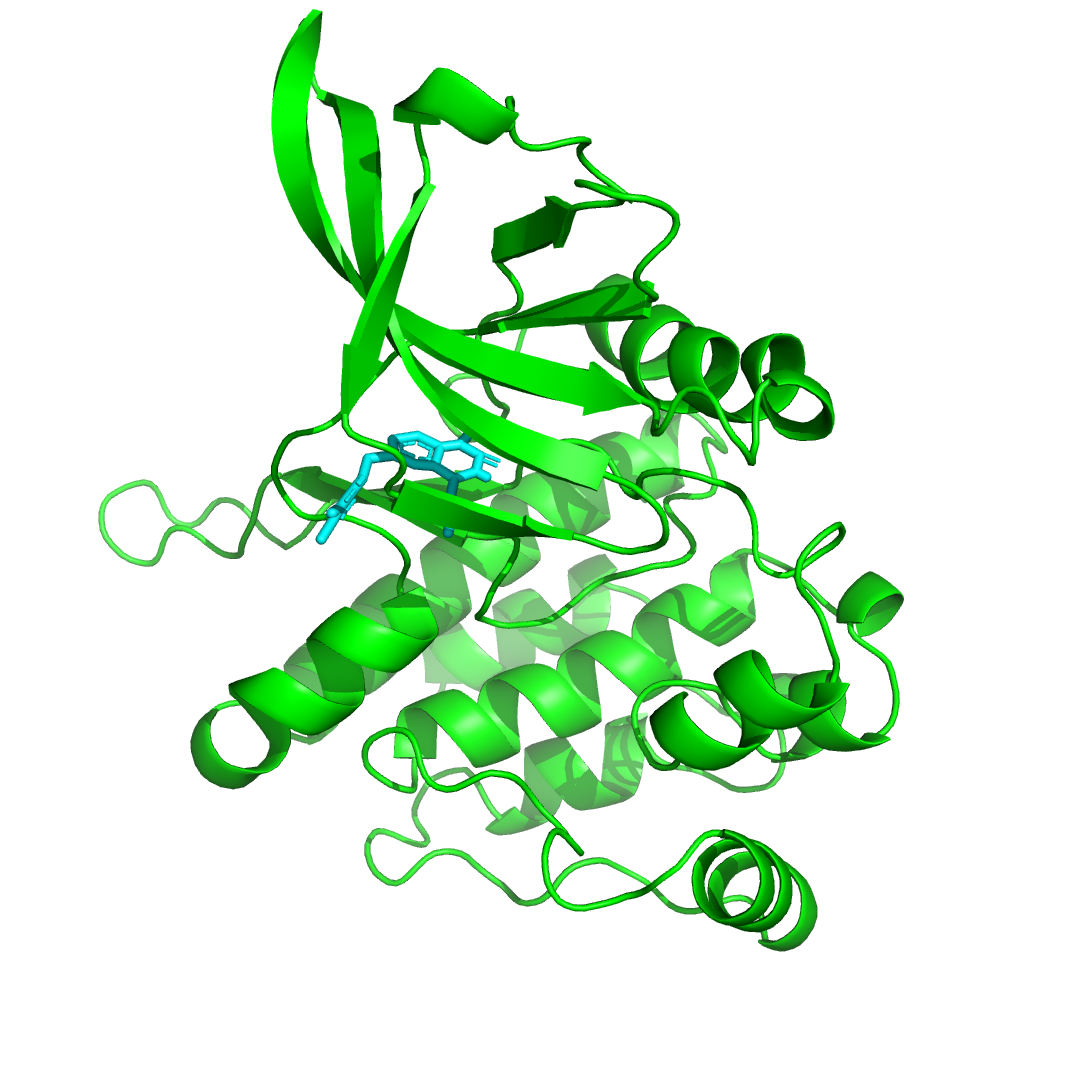

 25%|██▌       | 1/4 [00:03<00:09,  3.12s/it]

=======6n93=======


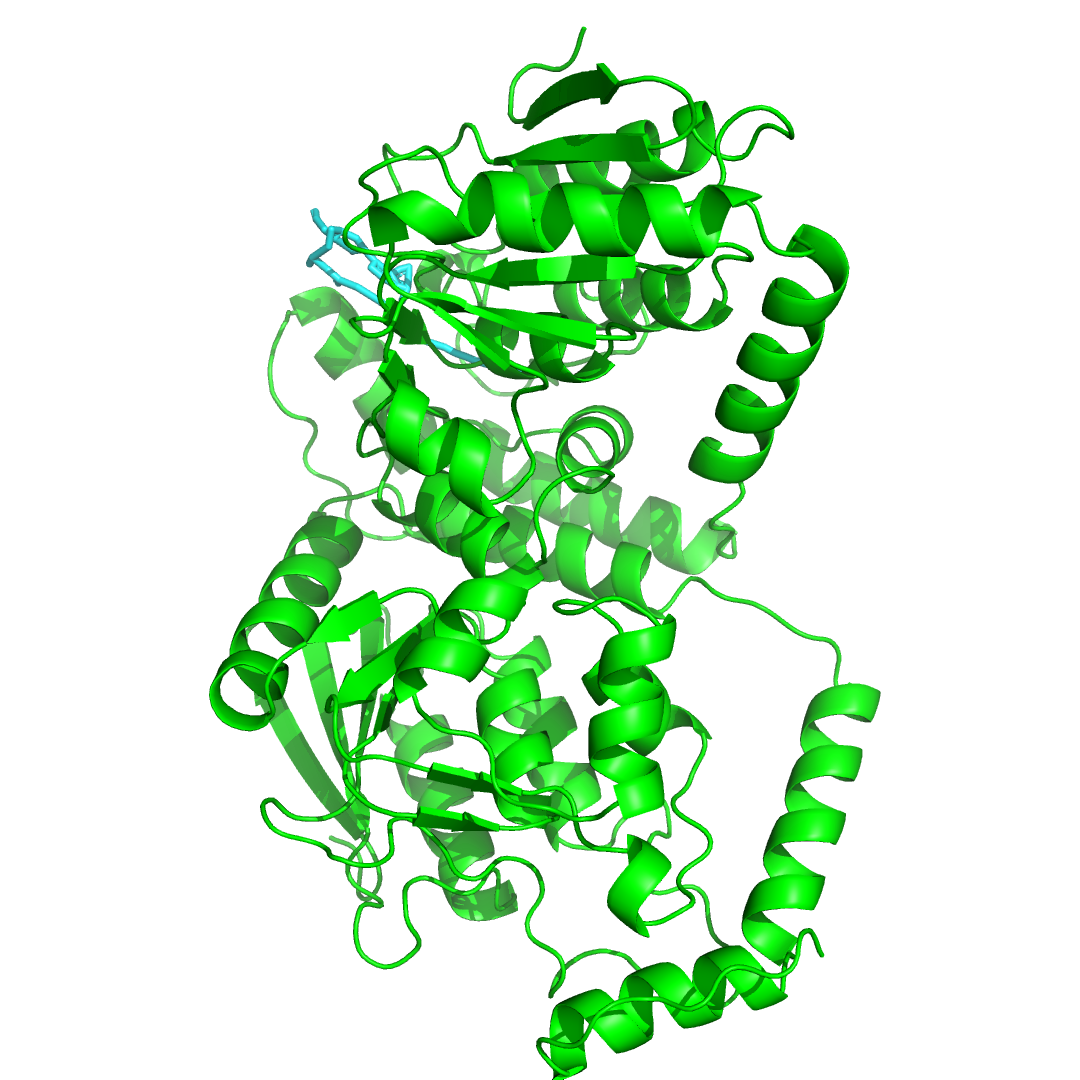

 50%|█████     | 2/4 [00:08<00:08,  4.24s/it]

=======6efk=======


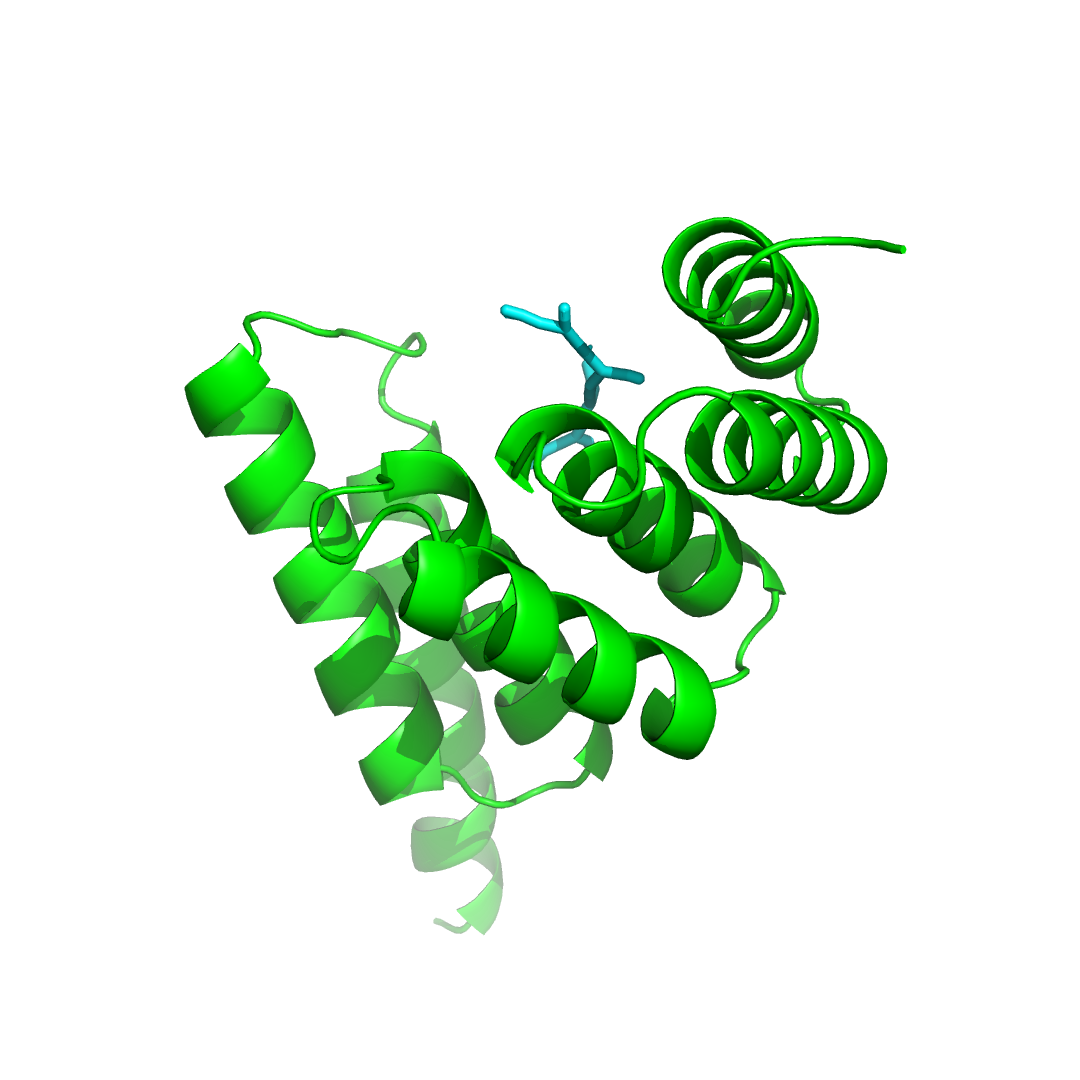

 75%|███████▌  | 3/4 [00:09<00:03,  3.15s/it]

=======6npi=======


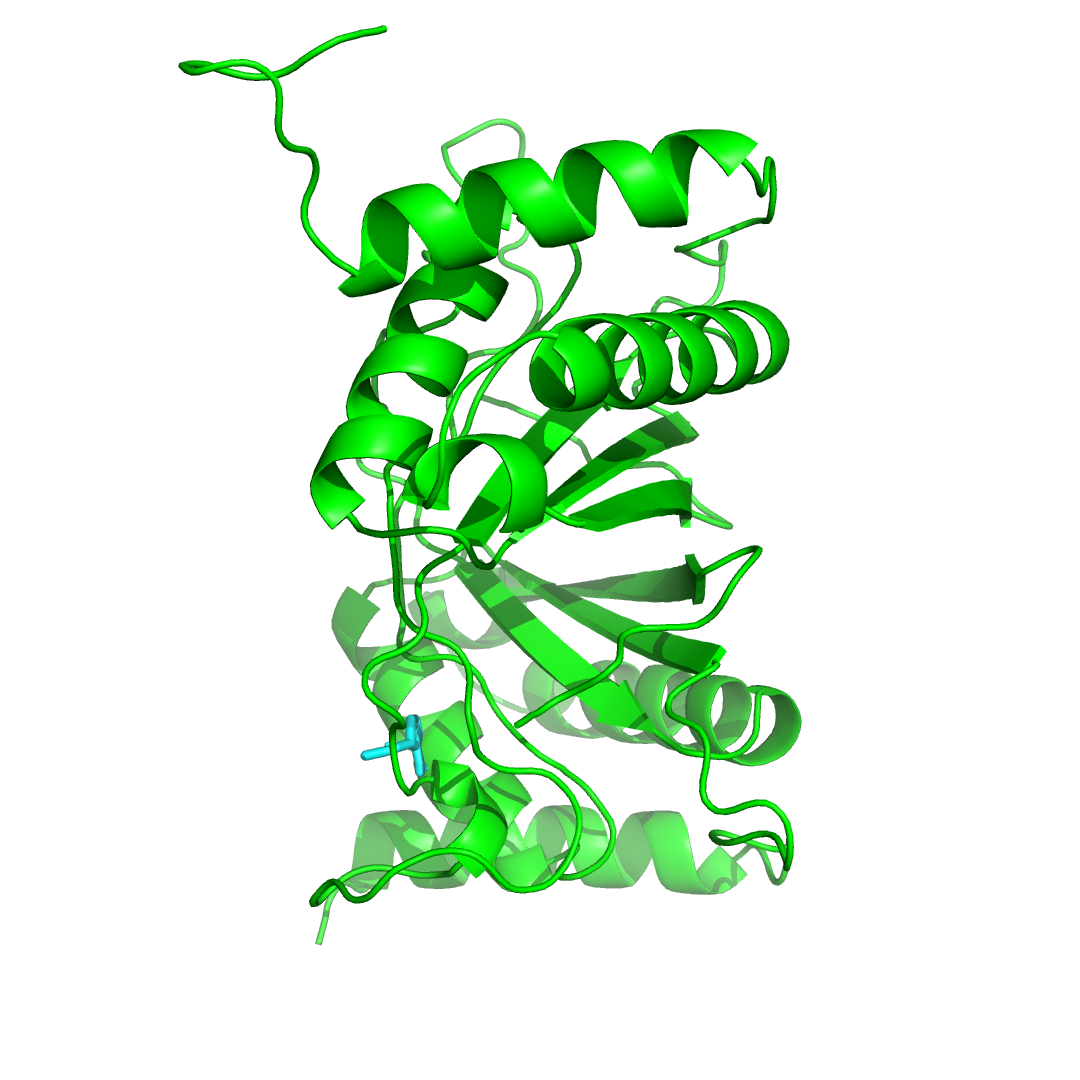

100%|██████████| 4/4 [00:12<00:00,  3.21s/it]


In [16]:
setup_PyMOL()
for pdb_p, ligand_p in tqdm(paired_files):
    process_pdb(pdb_p, ligand_p)